# Traffic Data from OverpassAPI

In this notebook, we look at the geographical range for which EDF collected the air quality data in Houstan. The coordinates for the area around Houston is based on minimum and maximum of latitude and longtitude from the EDF data.
We chose this area as the bounding box to determine location of all traffic signals/ intersections within that boundary.

[The Overpass API from Open Street Maps](https://wiki.openstreetmap.org/wiki/Overpass_API) is used to determine the location of all traffic signals (intersections) within a given bounding box. The Overpy library is used to send the request to the API and this call returns the latitude and longitude of all traffic signals. Next, the distance between each traffic intersection and each point in the monitoring data is measured. **A traffic score is calculated as the 'Number of traffic intersections within 1,000 ft to each point in the monitoring data.**

In addition to intersections, we will also extend the analysis to look at the location of bus stops and highways.

<!-- The second section of this notebook uses the Overpass API to get the latitude and longitude of all points within a bounding box classified as a highway. Next, the distance from each monitoring location to the closest highway is determined. -->

In [91]:
#Import python packages including overpy
import overpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
import geopy.distance
import math
import time
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas
import folium
import us
from matplotlib import cm
import matplotlib.lines as mlines

sns.set(style = 'whitegrid')
sns.set_palette('bright')
%matplotlib inline

In [92]:
#Bounding box for Houstan
# Lat_min - 29.59809873
# Lat_max - 29.8140199
# Lon_min - -95.557709
# Lon_max - -95.22848322

# Intersection data

In [93]:
#Call overpass API and pass bounding box to get all traffic intersections. 
# the api reads the bounding box as  (south,west,north,east)
api = overpy.Overpass()
result_intersections= api.query("""
    node(29.59809873,-95.557709,29.8140199,-95.22848322) ["highway"="traffic_signals"];
    (._;>;);
    out body;
    """)
traffic_lat = []
traffic_lon = []
for node in result_intersections.nodes:
    traffic_lat.append(node.lat)
    traffic_lon.append(node.lon)

In [94]:
#Write Latitude and Longitude data to a dataframe
traffic_df = pd.DataFrame(list(zip(traffic_lat, traffic_lon)), columns = ['Latitude', 'Longitude'])
len(traffic_df)

3953

In [95]:
# write traffic_df to a csv
traffic_df.to_csv("../../data/raw/intersection_locations.csv")

In [96]:
# Load traffic intersection data and clean it
traffic_df = pd.read_csv("../../data/raw/intersection_locations.csv")
#Drop the first column
traffic_df.drop(columns = ['Unnamed: 0'], inplace=True)
## Rename index and intersection number
traffic_df.rename(columns = {'index':'Intersection'}, inplace=True)
### Add an empty column for distance
traffic_df['dist'] = 0.0

In [97]:
traffic_df.head()

Latitude  Longitude  dist
0  29.680002 -95.458484   0.0
1  29.625999 -95.518213   0.0
2  29.626346 -95.517283   0.0
3  29.675718 -95.232807   0.0
4  29.770195 -95.343452   0.0

In [98]:
# Create individual dataframes
traffic_lat = traffic_df.filter(['Intersection','Latitude'], axis=1)
traffic_long = traffic_df.filter(['Intersection','Longitude'], axis=1)
traffic_dist = traffic_df.filter(['Intersection','dist'], axis=1)

In [99]:
# Transpose all the dataframes
traffic_lat = traffic_lat.T
traffic_long = traffic_long.T
traffic_dist  = traffic_dist.T

In [100]:
#Add suffix to column header based on the dataframe type
traffic_lat.columns = [str(col) + '_latitude' for col in traffic_lat.columns]
traffic_long.columns = [str(col) + '_longitude' for col in traffic_long.columns]
traffic_dist.columns = [str(col) + '_distance' for col in traffic_dist.columns]

In [101]:
## Remove index for each dataframe
traffic_lat.reset_index(drop=True, inplace=True)
traffic_long.reset_index(drop=True, inplace=True)
traffic_dist.reset_index(drop=True, inplace=True)

In [102]:
### Combine individual dataframes into one
traffic_combined = traffic_lat.join(traffic_long).join(traffic_dist)

In [103]:
### Sort based on column names
traffic_combined = traffic_combined.reindex(columns=sorted(traffic_combined.columns))
#Update dataframe to contain 11534 rows
traffic_combined = traffic_combined.loc[traffic_combined.index.repeat(11534)].reset_index(drop=True)

## Load EDF Data

In [104]:
NO2_raw = pd.read_csv("../../data/cleaned/air_quality_NO2.csv")

In [105]:
NO2_raw.shape

(11534, 12)

In [106]:
NO2_raw.head()

Unnamed: 0  locationId  location     city country  \
0           0       61509       NaN  Houston      US   
1           1       61509       NaN  Houston      US   
2           2       61509       NaN  Houston      US   
3           3       61509       NaN  Houston      US   
4           4       61509       NaN  Houston      US   

                         utc                      local parameter     value  \
0  2018-03-31T06:00:00+00:00  2018-03-31T01:00:00-05:00       no2  0.000517   
1  2018-03-31T06:00:00+00:00  2018-03-31T01:00:00-05:00       no2  0.000756   
2  2018-03-31T06:00:00+00:00  2018-03-31T01:00:00-05:00       no2  0.001427   
3  2018-03-31T06:00:00+00:00  2018-03-31T01:00:00-05:00       no2  0.001262   
4  2018-03-31T06:00:00+00:00  2018-03-31T01:00:00-05:00       no2  0.000803   

  unit   latitude  longitude  
0  ppm  29.789446 -95.483822  
1  ppm  29.750588 -95.419853  
2  ppm  29.810590 -95.348540  
3  ppm  29.786917 -95.298818  
4  ppm  29.604903 -95.364682

In [107]:
NO2_df = NO2_raw[['longitude', 'latitude', 'value']]

# Combine EDF data with traffic intersection data

In [108]:
combined_NO2_traffic = NO2_df.join(traffic_combined)
combined_NO2_traffic.head()

longitude   latitude     value  0_distance  0_latitude  0_longitude  \
0 -95.483822  29.789446  0.000517         0.0   29.680002   -95.458484   
1 -95.419853  29.750588  0.000756         0.0   29.680002   -95.458484   
2 -95.348540  29.810590  0.001427         0.0   29.680002   -95.458484   
3 -95.298818  29.786917  0.001262         0.0   29.680002   -95.458484   
4 -95.364682  29.604903  0.000803         0.0   29.680002   -95.458484   

   1000_distance  1000_latitude  1000_longitude  1001_distance  ...  \
0            0.0      29.744669      -95.410643            0.0  ...   
1            0.0      29.744669      -95.410643            0.0  ...   
2            0.0      29.744669      -95.410643            0.0  ...   
3            0.0      29.744669      -95.410643            0.0  ...   
4            0.0      29.744669      -95.410643            0.0  ...   

   998_longitude  999_distance  999_latitude  999_longitude  99_distance  \
0     -95.467527           0.0     29.796032     -95.409997          0.0   
1     -95.467527           0.0     29.796032     -95.409997          0.0   
2     -95.467527           0.0     29.796032     -95.409997          0.0   
3     -95.467527           0.0     29.796032     -95.409997          0.0   
4     -95.467527           0.0     29.796032     -95.409997          0.0   

   99_latitude  99_longitude  9_distance  9_latitude  9_longitude  
0    29.748337    -95.361603         0.0   29.718541   -95.408966  
1    29.748337    -95.361603         0.0   29.718541   -95.408966  
2    29.748337    -95.361603         0.0   29.718541   -95.408966  
3    29.748337    -95.361603         0.0   29.718541   -95.408966  
4    29.748337    -95.361603         0.0   29.718541   -95.408966  

[5 rows x 11862 columns]

# Calculate distance between monitoring location and each traffic intersection

Calculate the distance between the latitude and longitude of the monitoring location from EDF data, and the latitude and longitdue of the intersection using the distance function defined below. The function uses two GPS coordinates to calculate geodesic distance.

In [110]:
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [111]:
time1 = time.time()
for index, row in combined_NO2_traffic.iterrows():
    for idx, col in enumerate(combined_NO2_traffic.columns):
        if "_dist" in col:
            combined_NO2_traffic.at[index,col] = distance((row.iloc[1], row.iloc[0]), (row.iloc[idx+1], row.iloc[idx+2]))*3280.84
    if index % 1000 == 0:
        print(f"Completed {index} row")
time2 = time.time()         
print(time2 - time1)

Completed 0 row
Completed 1000 row
Completed 2000 row
Completed 3000 row
Completed 4000 row
Completed 5000 row
Completed 6000 row
Completed 7000 row
Completed 8000 row
Completed 9000 row
Completed 10000 row
Completed 11000 row
1427.0779378414154


In [113]:
combined_NO2_traffic.head()

longitude   latitude     value    0_distance  0_latitude  0_longitude  \
0 -95.483822  29.789446  0.000517  40725.511875   29.680002   -95.458484   
1 -95.419853  29.750588  0.000756  28511.795119   29.680002   -95.458484   
2 -95.348540  29.810590  0.001427  59011.178470   29.680002   -95.458484   
3 -95.298818  29.786917  0.001262  63871.870377   29.680002   -95.458484   
4 -95.364682  29.604903  0.000803  40437.225704   29.680002   -95.458484   

   1000_distance  1000_latitude  1000_longitude  1001_distance  ...  \
0   28352.829723      29.744669      -95.410643   50973.139812  ...   
1    3629.325573      29.744669      -95.410643   30366.126537  ...   
2   31064.999638      29.744669      -95.410643   54571.766478  ...   
3   38621.552841      29.744669      -95.410643   54309.290510  ...   
4   53028.664951      29.744669      -95.410643   26232.235487  ...   

   998_longitude  999_distance  999_latitude  999_longitude   99_distance  \
0     -95.467527  23495.893251     29.796032     -95.409997  41507.399839   
1     -95.467527  16869.683314     29.796032     -95.409997  18467.923850   
2     -95.467527  20166.668812     29.796032     -95.409997  23084.186283   
3     -95.467527  35355.987934     29.796032     -95.409997  24359.797049   
4     -95.467527  71189.485295     29.796032     -95.409997  52335.644540   

   99_latitude  99_longitude    9_distance  9_latitude  9_longitude  
0    29.748337    -95.361603  35088.338040   29.718541   -95.408966  
1    29.748337    -95.361603  12189.239614   29.718541   -95.408966  
2    29.748337    -95.361603  38650.270495   29.718541   -95.408966  
3    29.748337    -95.361603  42886.927304   29.718541   -95.408966  
4    29.748337    -95.361603  43768.914498   29.718541   -95.408966  

[5 rows x 11862 columns]

# Clean Traffic+Distance data

In [121]:
#Read dataset
NO2_traffic_dist = combined_NO2_traffic.copy()

In [122]:
#Drop the latitude column
NO2_traffic_dist = NO2_traffic_dist[NO2_traffic_dist.columns.drop(list(NO2_traffic_dist.filter(regex='_latitude')))]
#Drop the longitude column
NO2_traffic_dist = NO2_traffic_dist[NO2_traffic_dist.columns.drop(list(NO2_traffic_dist.filter(regex='_longitude')))]
#Drop NO2 value
#NO2_traffic_dist.drop(columns = ["value"], inplace = True)

In [123]:
#Clean-up the columns
# NO2_traffic_dist.drop(columns = ['Unnamed: 0'], inplace=True)
NO2_traffic_dist.shape

(11534, 3956)

In [124]:
NO2_traffic_dist.head()

longitude   latitude     value    0_distance  1000_distance  1001_distance  \
0 -95.483822  29.789446  0.000517  40725.511875   28352.829723   50973.139812   
1 -95.419853  29.750588  0.000756  28511.795119    3629.325573   30366.126537   
2 -95.348540  29.810590  0.001427  59011.178470   31064.999638   54571.766478   
3 -95.298818  29.786917  0.001262  63871.870377   38621.552841   54309.290510   
4 -95.364682  29.604903  0.000803  40437.225704   53028.664951   26232.235487   

   1002_distance  1003_distance  1004_distance  1005_distance  ...  \
0   29677.641257   36289.436580   38254.241012   72090.489274  ...   
1    4953.077111   14385.804078   40865.493056   47424.413852  ...   
2   30920.477744   21038.485763   71856.605512   49286.816183  ...   
3   37882.469139   26419.336813   80972.987499   37181.522781  ...   
4   52054.103693   55864.106351   61479.194619   37594.513538  ...   

   992_distance  993_distance  994_distance  995_distance  996_distance  \
0  23104.525543  30880.345672  33582.794700  36910.881441  36960.540472   
1  17447.084727  22302.447979  24350.553224  27062.418280  27111.376345   
2  48490.779744  53735.357748  55689.627895  58209.126581  58255.617803   
3  57830.171800  61172.886024  62513.509052  64320.033370  64357.901721   
4  55489.111612  49293.240629  47265.551029  44901.455815  44874.166340   

   997_distance  998_distance  999_distance   99_distance    9_distance  
0  36922.223048  36977.216784  23495.893251  41507.399839  35088.338040  
1  27011.643458  27049.240088  16869.683314  18467.923850  12189.239614  
2  58150.597010  58183.463350  20166.668812  23084.186283  38650.270495  
3  64245.354872  64264.827364  35355.987934  24359.797049  42886.927304  
4  44837.226022  44791.249414  71189.485295  52335.644540  43768.914498  

[5 rows x 3956 columns]

# Count the number of intersections with distance less than 1000 ft

In [125]:
#Create an empty column for number of intersection
NO2_traffic_dist['number_intersections'] = 0

In [126]:
def count_values_in_range(series, range_min, range_max):
    # "between" returns a boolean Series equivalent to left <= series <= right.
    # NA values will be treated as False.
    return series.between(left=range_min, right=range_max).sum()

range_min, range_max = 0, 1000

NO2_traffic_dist['number_intersections'] = NO2_traffic_dist.iloc[:,2:].apply(
    func=lambda row: count_values_in_range(row, range_min, range_max), axis=1)

In [127]:
#Keep only coordinates of the monitoring station and number of intersections for each in the final dataset
NO2_traffic_score = NO2_traffic_dist[['latitude','longitude','number_intersections']]

In [128]:
NO2_traffic_score.describe()

latitude     longitude  number_intersections
count  11534.000000  11534.000000          11534.000000
mean      29.728743    -95.378613              3.577163
std        0.059185      0.090387              2.636721
min       29.598099    -95.557709              2.000000
25%       29.702324    -95.434617              2.000000
50%       29.727755    -95.382017              2.000000
75%       29.780144    -95.300010              5.000000
max       29.814020    -95.228483             27.000000

In [129]:
#Write to a csv file
NO2_traffic_score.to_csv("../../data/cleaned/intersection_final.csv")

### Visualization

In [140]:
plot_data=NO2_traffic_dist[['latitude','longitude','number_intersections', 'value']]
plot_data.head()

latitude  longitude  number_intersections     value
0  29.789446 -95.483822                     2  0.000517
1  29.750588 -95.419853                     7  0.000756
2  29.810590 -95.348540                     2  0.001427
3  29.786917 -95.298818                     2  0.001262
4  29.604903 -95.364682                     2  0.000803

In [165]:
from branca.element import Figure
fig2 = Figure()
houstan_map = folium.Map(location=[NO2_df.latitude.mean(), 
                           NO2_df.longitude.mean()], 
                 zoom_start=12, control_scale=True)

In [166]:
for _, intersection in traffic_df.iterrows():
    folium.CircleMarker(
        location = (intersection['Latitude'], intersection['Longitude']), 
        radius=2, 
        weight=2, fill_color='red', fill_opacity=0.6).add_to(houstan_map)
# for _, stations in NO2_df.iterrows():
#     folium.Marker(
#         location = (stations['latitude'], stations['longitude']), 
#         icon = folium.Icon(color='red', icon='flag', prefix='fa')).add_to(houstan_map)

# houstan_map  

In [167]:
from folium.plugins import HeatMap
heatmap = HeatMap( list(zip(plot_data['latitude'], plot_data['longitude'], plot_data['value'])),
                   min_opacity=0.2,
                   max_val=plot_data['value'].max(),
                   radius=20, blur=2, 
                   max_zoom=80)
# add heatmap layer to base map
heatmap.add_to(houstan_map)
houstan_map

<ipython-input-167-fc45dda86cdf>:2: UserWarning:

The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.



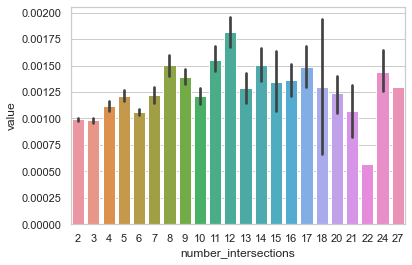

In [134]:
sns.barplot( NO2_traffic_dist["number_intersections"],NO2_traffic_dist["value"])

In [149]:
# plotting map to compare with EDF study
import plotly.express as px
px.set_mapbox_access_token("pk.eyJ1IjoidmlzaGFsdmpvc2VwaCIsImEiOiJjbDM2Y3hxaTMzYnlsM2JwZmoxZm9sZjZxIn0.ARpv_l4hUbukED2DPkPuxg")
fig = px.scatter_mapbox(plot_data, lat="latitude", lon="longitude", 
                        color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
fig.show()


# Bus stop data

In [8]:
#Call overpass API and pass bounding box to get all traffic intersections. 
# the api reads the bounding box as  (south,west,north,east)
api = overpy.Overpass()
result_bus_stop = api.query("""
    node(29.59809873,-95.557709,29.8140199,-95.22848322) ["highway"="bus_stop"];
    (._;>;);
    out body;
    """)
bus_stop_lat = []
bus_stop_lon = []
for node in result_bus_stop.nodes:
    bus_stop_lat.append(node.lat)
    bus_stop_lon.append(node.lon)

In [12]:
#Write Latitude and Longitude data to a dataframe. It has 243 observations
bus_stop_df = pd.DataFrame(list(zip(bus_stop_lat, bus_stop_lon)), columns = ['Latitude', 'Longitude'])
len(bus_stop_df)

243

In [13]:
# write traffic_df to a csv
bus_stop_df.to_csv("../../data/raw/bus_stop_locations.csv")

In [30]:
# Load traffic intersection data and clean it
bus_stop_df = pd.read_csv("../../data/raw/bus_stop_locations.csv")
#Drop the first column
bus_stop_df.drop(columns = ['Unnamed: 0'], inplace=True)
## Rename index and intersection number
bus_stop_df.rename(columns = {'index':'Bus_stops'}, inplace=True)
### Add an empty column for distance
bus_stop_df['dist'] = 0.0

In [31]:
# Create individual dataframes
bus_stop_lat = bus_stop_df.filter(['Bus_stops','Latitude'], axis=1)
bus_stop_long = bus_stop_df.filter(['Bus_stops','Longitude'], axis=1)
bus_stop_dist = bus_stop_df.filter(['Bus_stops','dist'], axis=1)

In [32]:
# Transpose all the dataframes
bus_stop_lat = bus_stop_lat.T
bus_stop_long = bus_stop_long.T
bus_stop_dist  = bus_stop_dist.T

In [33]:
#Add suffix to column header based on the dataframe type
bus_stop_lat.columns = [str(col) + '_latitude' for col in bus_stop_lat.columns]
bus_stop_long.columns = [str(col) + '_longitude' for col in bus_stop_long.columns]
bus_stop_dist.columns = [str(col) + '_distance' for col in bus_stop_dist.columns]

In [34]:
bus_stop_lat.columns

Index(['0_latitude', '1_latitude', '2_latitude', '3_latitude', '4_latitude',
       '5_latitude', '6_latitude', '7_latitude', '8_latitude', '9_latitude',
       ...
       '233_latitude', '234_latitude', '235_latitude', '236_latitude',
       '237_latitude', '238_latitude', '239_latitude', '240_latitude',
       '241_latitude', '242_latitude'],
      dtype='object', length=243)

In [35]:
## Remove index for each dataframe
bus_stop_lat.reset_index(drop=True, inplace=True)
bus_stop_long.reset_index(drop=True, inplace=True)
bus_stop_dist.reset_index(drop=True, inplace=True)

In [36]:
### Combine individual dataframes into one
bus_stop_combined = bus_stop_lat.join(bus_stop_long).join(bus_stop_dist)

In [37]:
### Sort based on column names
bus_stop_combined = bus_stop_combined.reindex(columns=sorted(bus_stop_combined.columns))
#Update dataframe to contain 11534 rows
bus_stop_combined = bus_stop_combined.loc[bus_stop_combined.index.repeat(11534)].reset_index(drop=True)

In [38]:
bus_stop_combined.head()

0_distance  0_latitude  0_longitude  100_distance  100_latitude  \
0         0.0   29.716377   -95.402005           0.0     29.705612   
1         0.0   29.716377   -95.402005           0.0     29.705612   
2         0.0   29.716377   -95.402005           0.0     29.705612   
3         0.0   29.716377   -95.402005           0.0     29.705612   
4         0.0   29.716377   -95.402005           0.0     29.705612   

   100_longitude  101_distance  101_latitude  101_longitude  102_distance  \
0     -95.492543           0.0     29.720677     -95.401411           0.0   
1     -95.492543           0.0     29.720677     -95.401411           0.0   
2     -95.492543           0.0     29.720677     -95.401411           0.0   
3     -95.492543           0.0     29.720677     -95.401411           0.0   
4     -95.492543           0.0     29.720677     -95.401411           0.0   

   ...  97_longitude  98_distance  98_latitude  98_longitude  99_distance  \
0  ...    -95.338534          0.0    29.725577    -95.343688          0.0   
1  ...    -95.338534          0.0    29.725577    -95.343688          0.0   
2  ...    -95.338534          0.0    29.725577    -95.343688          0.0   
3  ...    -95.338534          0.0    29.725577    -95.343688          0.0   
4  ...    -95.338534          0.0    29.725577    -95.343688          0.0   

   99_latitude  99_longitude  9_distance  9_latitude  9_longitude  
0    29.750264    -95.371763         0.0   29.761878   -95.408439  
1    29.750264    -95.371763         0.0   29.761878   -95.408439  
2    29.750264    -95.371763         0.0   29.761878   -95.408439  
3    29.750264    -95.371763         0.0   29.761878   -95.408439  
4    29.750264    -95.371763         0.0   29.761878   -95.408439  

[5 rows x 729 columns]

## Combine bus stops data with EDF data on NO2

In [45]:
combined_NO2_bus_stop = NO2_df.join(bus_stop_combined)

In [46]:
combined_NO2_bus_stop.head()

longitude   latitude     value  0_distance  0_latitude  0_longitude  \
0 -95.483822  29.789446  0.000517         0.0   29.716377   -95.402005   
1 -95.419853  29.750588  0.000756         0.0   29.716377   -95.402005   
2 -95.348540  29.810590  0.001427         0.0   29.716377   -95.402005   
3 -95.298818  29.786917  0.001262         0.0   29.716377   -95.402005   
4 -95.364682  29.604903  0.000803         0.0   29.716377   -95.402005   

   100_distance  100_latitude  100_longitude  101_distance  ...  97_longitude  \
0           0.0     29.705612     -95.492543           0.0  ...    -95.338534   
1           0.0     29.705612     -95.492543           0.0  ...    -95.338534   
2           0.0     29.705612     -95.492543           0.0  ...    -95.338534   
3           0.0     29.705612     -95.492543           0.0  ...    -95.338534   
4           0.0     29.705612     -95.492543           0.0  ...    -95.338534   

   98_distance  98_latitude  98_longitude  99_distance  99_latitude  \
0          0.0    29.725577    -95.343688          0.0    29.750264   
1          0.0    29.725577    -95.343688          0.0    29.750264   
2          0.0    29.725577    -95.343688          0.0    29.750264   
3          0.0    29.725577    -95.343688          0.0    29.750264   
4          0.0    29.725577    -95.343688          0.0    29.750264   

   99_longitude  9_distance  9_latitude  9_longitude  
0    -95.371763         0.0   29.761878   -95.408439  
1    -95.371763         0.0   29.761878   -95.408439  
2    -95.371763         0.0   29.761878   -95.408439  
3    -95.371763         0.0   29.761878   -95.408439  
4    -95.371763         0.0   29.761878   -95.408439  

[5 rows x 732 columns]

## Calculate distance between monitoring location and each traffic intersection
Calculate the distance between the latitude and longitude of the monitoring location from EDF data, and the latitude and longitdue of the intersection using the distance function defined below. The function uses two GPS coordinates to calculate geodesic distance.

In [49]:
time1 = time.time()
for index, row in combined_NO2_bus_stop.iterrows():
    for idx, col in enumerate(combined_NO2_bus_stop.columns):
        if "_dist" in col:
            combined_NO2_bus_stop.at[index,col] = distance((row.iloc[1], row.iloc[0]), (row.iloc[idx+1], row.iloc[idx+2]))*3280.84
    if index % 1000 == 0:
        print(f"Completed {index} row")
time2 = time.time()         
print(time2 - time1)

Completed 0 row
Completed 1000 row
Completed 2000 row
Completed 3000 row
Completed 4000 row
Completed 5000 row
Completed 6000 row
Completed 7000 row
Completed 8000 row
Completed 9000 row
Completed 10000 row
Completed 11000 row
90.69502401351929


## Clean Bus stop +Distance data

In [52]:
#Make a copy of the dataset
NO2_bus_stop_dist = combined_NO2_bus_stop.copy()
#Drop the latitude column
NO2_bus_stop_dist = NO2_bus_stop_dist[NO2_bus_stop_dist.columns.drop(list(NO2_bus_stop_dist.filter(regex='_latitude')))]
#Drop the longitude column
NO2_bus_stop_dist = NO2_bus_stop_dist[NO2_bus_stop_dist.columns.drop(list(NO2_bus_stop_dist.filter(regex='_longitude')))]
#Drop NO2 value
NO2_bus_stop_dist.drop(columns = ["value"], inplace = True)
# check shape
NO2_bus_stop_dist.shape

(11534, 245)

## Count the number of bus stops with distance less than 1000 ft

In [54]:
#Create an empty column for number of intersection
NO2_bus_stop_dist['number_bus_stops'] = 0

In [55]:
def count_values_in_range(series, range_min, range_max):
    # "between" returns a boolean Series equivalent to left <= series <= right.
    # NA values will be treated as False.
    return series.between(left=range_min, right=range_max).sum()

range_min, range_max = 0, 1000

NO2_bus_stop_dist['number_bus_stops'] = NO2_bus_stop_dist.iloc[:,2:].apply(
    func=lambda row: count_values_in_range(row, range_min, range_max), axis=1)

In [56]:
#Keep only coordinates of the monitoring station and number of bus_stops for each in the final dataset
NO2_bus_stop_score = NO2_bus_stop_dist[['latitude','longitude','number_bus_stops']]

In [57]:
NO2_bus_stop_score.describe()

latitude     longitude  number_bus_stops
count  11534.000000  11534.000000      11534.000000
mean      29.728743    -95.378613          2.176695
std        0.059185      0.090387          0.861717
min       29.598099    -95.557709          2.000000
25%       29.702324    -95.434617          2.000000
50%       29.727755    -95.382017          2.000000
75%       29.780144    -95.300010          2.000000
max       29.814020    -95.228483         11.000000

In [58]:
NO2_bus_stop_score.head()

latitude  longitude  number_bus_stops
0  29.789446 -95.483822                 2
1  29.750588 -95.419853                 3
2  29.810590 -95.348540                 2
3  29.786917 -95.298818                 2
4  29.604903 -95.364682                 2

### References:

* [Hyperlocal Air Quality Prediction using Machine Learning](https://towardsdatascience.com/hyperlocal-air-quality-prediction-using-machine-learning-ed3a661b9a71)
* [Overpass API/Language Guide](https://wiki.openstreetmap.org/wiki/Overpass_API/Language_Guide#Retrieving_all_nodes_within_a_bounding_box)
* [EDF Data](https://www.edf.org/maps/airqualitymaps/houston/pollution-map/)